# Alzheption Feature Extraction and Classification

## Packages

In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import torch
import tensorflow as tf
import torchvision as tv
from PIL import Image

from alzheption.clahe import Clahe
from alzheption.extractor import AlzheptionExtractor

2025-03-02 14:52:41.730087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740901961.751115   21482 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740901961.756711   21482 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 14:52:41.776286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocess

In [3]:
# # Transformation 1
# train_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Transformation 2
# train_transform = tv.transforms.Compose([
#     tv.transforms.RandomResizedCrop(299),
#     tv.transforms.RandomHorizontalFlip(),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = tv.transforms.Compose([
#     tv.transforms.Resize((299, 299)),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Transformation 3
# train_transform = tv.transforms.Compose([
#     Clahe(),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = tv.transforms.Compose([
#     Clahe(),
#     tv.transforms.ToTensor(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Transformation 4
# train_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     Clahe(),
#     tv.transforms.RandomResizedCrop(299),
#     tv.transforms.RandomHorizontalFlip(),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# test_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     Clahe(),
#     tv.transforms.Resize((299, 299)),
#     tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Base Transformation
# train_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     Clahe(),
#     tv.transforms.Resize((299, 299)),
# ])

# test_transform = tv.transforms.Compose([
#     tv.transforms.ToTensor(),
#     Clahe(),
#     tv.transforms.Resize((299, 299)),
# ])

# Base Transformation
train_transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize((299, 299)),
])

test_transform = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize((299, 299)),
])

## Feature Extraction

In [4]:
alex_1 = AlzheptionExtractor(
    path_dataset='../../asset/dataset_jpg_brightness_balance/',
    test_size=0.2,
    train_transform=train_transform,
    test_transform=test_transform,
)

alex_1.show_dataset_count()

Train dataset size : 456
Test dataset size  : 114


In [5]:
# # Load dataset without transformations
# dataset = tv.datasets.ImageFolder('dataset_jpg_brightness')

# # Split dataset into train and test sets
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_indices, test_indices = torch.utils.data.random_split(range(len(dataset)), [train_size, test_size])

# # Create Subsets with the different transforms applied
# train_dataset = torch.utils.data.Subset(tv.datasets.ImageFolder('dataset_jpg_brightness', transform=train_transform), train_indices.indices)
# test_dataset = torch.utils.data.Subset(tv.datasets.ImageFolder('dataset_jpg_brightness', transform=test_transform), test_indices.indices)

# # DataLoader
# batch_size = 256
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# print(f"Train dataset size: {len(train_dataset)}")
# print(f"Test dataset size: {len(test_dataset)}")

Original Data Test Sample

Get sample of original dataset (test) with index: 24



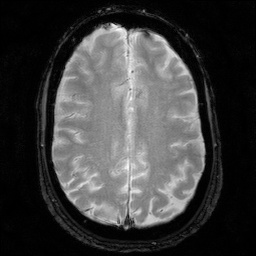

In [6]:
alex_1.get_sample_of_original_dataset(part="test")

Preprocessed Data Test Sample

Get sample of preprocessed dataset (test) with index: 0



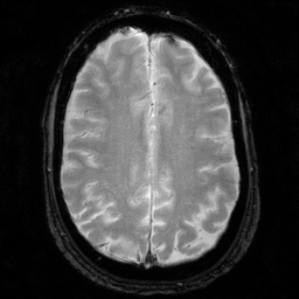

In [7]:
alex_1.get_sample_of_preprocessed_dataset(part="test")

In [8]:
# Load pre-trained InceptionV3 model and set as feature extractor
model = tv.models.inception_v3(weights=True)
model.aux_logits = False
model.fc = torch.nn.Identity()  # Replace fully connected layer with identity for feature extraction

# Move model to GPU if available and use DataParallel
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs!')
    model = torch.nn.DataParallel(model)
model = model.to(device)

/home/febriantohuda/projects/alzheption/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extract Features

In [9]:
train_features, test_features = alex_1()

Extracting 'test': 100%|██████████| 1/1 [00:09<00:00,  9.13s/it]


Save Features

In [13]:
alex_1.save_extractor("result/")